In [14]:
%load_ext autoreload
%autoreload 2
from models.diffusion import StableDiffusion
import torch
from torchvision import transforms
from transformers import CLIPTokenizer
from PIL import Image
from utils.model_converter import load_weights_from_ckpt


prompt = "A cat stretching on the floor"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# Comment to disable image to image
# image_path = "./images/dog.jpg"
# input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 1.0

## SAMPLER
num_inference_steps = 50
seed = 42

model = StableDiffusion()
loaded_state_dict = load_weights_from_ckpt('./weights/model/v1-5-pruned-emaonly.ckpt', device='cpu')
model.vae.load_state_dict(loaded_state_dict['vae'], strict=True)
model.unet.load_state_dict(loaded_state_dict['unet'], strict=True)
model.cond_encoder.load_state_dict(loaded_state_dict['cond_encoder'], strict=True)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<All keys matched successfully>

In [17]:
output = model.generate(input_image=None,
                        prompt=prompt,
                        uncond_promt=uncond_prompt,
                        do_cfg=do_cfg,
                        cfg_scale=cfg_scale,
                        device='mps',
                        strength=strength,
                        inference_steps=num_inference_steps,
                        sampler='ddim',
                        use_cosine_schedule=False,
                        tokenizer=CLIPTokenizer('./weights/tokenizer/tokenizer_vocab.json', merges_file='./weights/tokenizer/tokenizer_merges.txt')
                       )


100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.48s/it]


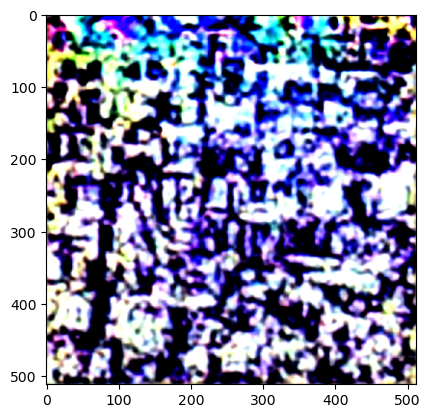

In [18]:
from matplotlib import pyplot as plt
plt.imshow(output)